In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
from itertools import product

import numpy as np
from graspy.embed import MultipleASE, OmnibusEmbed
from graspy.cluster import AutoGMMCluster, GaussianCluster
from graspy.simulations import er_np, sbm
from graspy.models import SBMEstimator
from graspy.plot import heatmap
from scipy.stats import ttest_ind
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

/env/miniconda3/envs/dnd/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.mixture.gaussian_mixture module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.mixture. Anything that cannot be imported from sklearn.mixture is now part of the private API.
  warnings.warn(message, FutureWarning)


<IPython.core.display.Javascript object>

In [3]:
def generate_data(m, n=[5, 15], p=0.5, delta=0):
    np.random.seed(None)

    if (p + delta > 1) or (p + delta < 1):
        assert ValueError("p + delta must be between [0, 1]")

    p1 = [[p, p], [p, p]]
    p2 = [[p + delta, p], [p, p]]

    X = np.stack([sbm(n, p1) for _ in np.arange(m)])
    Y = np.stack([sbm(n, p2) for _ in np.arange(m)])

    return X, Y


def experiment(m, num_sig_nodes, num_non_sig_nodes, delta, reps):
    mase_aris = np.zeros(reps)
    omni_aris = np.zeros(reps)

    true_labels = [0] * num_sig_nodes + [1] * num_non_sig_nodes

    for i in range(reps):
        X, Y = generate_data(m=m, n=[num_sig_nodes, num_non_sig_nodes], delta=delta)
        stacked = np.vstack([X, Y])

        mase = MultipleASE(2)
        embeddings = mase.fit_transform(stacked)
        gclust = GaussianCluster(2, 2)
        mase_results = gclust.fit_predict(embeddings, true_labels)
        mase_aris[i] = mase_results[1]

        omni = OmnibusEmbed(2)
        embeddings = omni.fit_transform(stacked).mean(axis=0)
        gclust = GaussianCluster(2, 2)
        omni_results = gclust.fit_predict(embeddings, true_labels)
        omni_aris[i] = omni_results[1]

    return m, num_sig_nodes, mase_aris.mean(), omni_aris.mean()

<IPython.core.display.Javascript object>

1. 1st vary the number of significant nodes and sample size (fix non-sig nodes = 15, fix delta=0.25, p = 0.5)

2. 2nd vary the number of non-significant nodes and sample size (fix sig nodes = 5, fix delta=0.25, p = 0.5)

In [4]:
# Experiment 1
spacing = 20
ms = np.linspace(0, 50, spacing + 1)[1:].astype(int)
num_sig_nodes = np.linspace(0, 100, spacing + 1)[1:].astype(int)
num_non_sig_nodes = 10
delta = 0.25
reps = 100

res = Parallel(n_jobs=-1, verbose=1)(
    delayed(experiment)(
        m=m,
        num_sig_nodes=n,
        num_non_sig_nodes=num_non_sig_nodes,
        delta=delta,
        reps=reps,
    )
    for m, n in product(ms, num_sig_nodes)
)

res_df = pd.DataFrame(res, columns=["m", "num_sig_nodes", "mase_ari", "omni_ari"])

res_df.to_csv("20200130_vary_sig_nodes.csv", index=False)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed: 23.5min finished


<IPython.core.display.Javascript object>

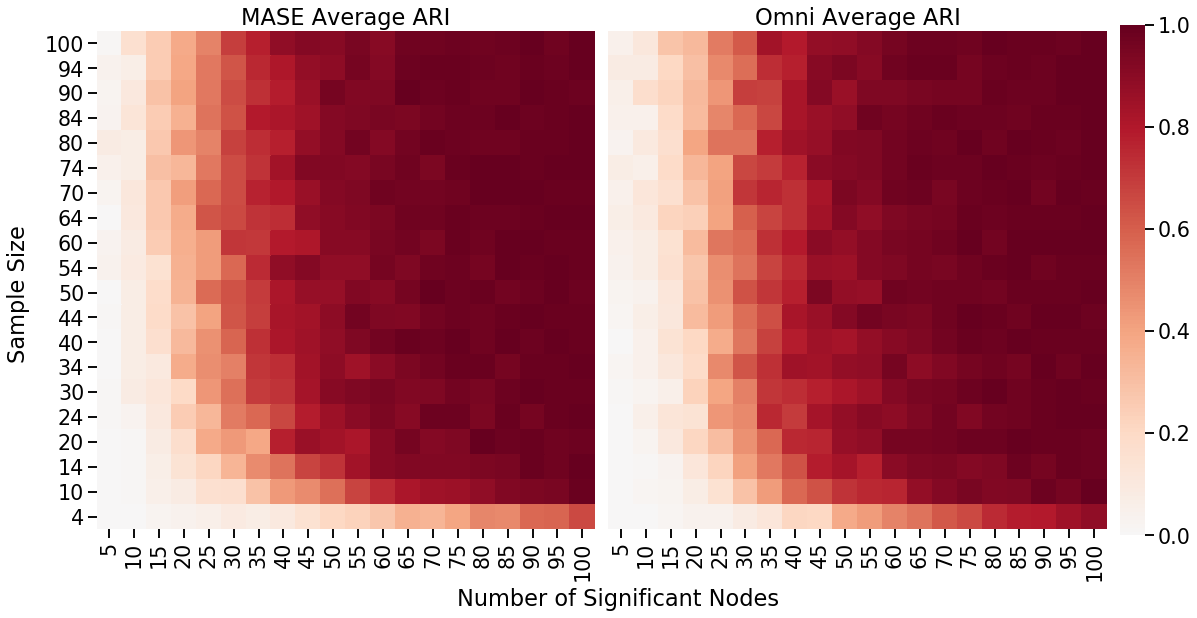

<IPython.core.display.Javascript object>

In [5]:
fmt = lambda x: "{:.2f}".format(x)

with sns.plotting_context("talk", font_scale=1.25):
    fig, ax = plt.subplots(
        1,
        3,
        gridspec_kw={"width_ratios": [1, 1, 0.05]},
        figsize=(16, 8),
        constrained_layout=True,
    )

    sns.heatmap(
        np.flipud(res_df.mase_ari.values.reshape(spacing, -1)),
        ax=ax[0],
        square=True,
        center=0,
        cmap="RdBu_r",
        cbar_kws=dict(shrink=0.7),
        xticklabels=num_sig_nodes,
        yticklabels=ms[::-1] * 2,
        cbar_ax=ax[-1],
        vmin=0,
        vmax=1,
    )
    ax[0].set_title("MASE Average ARI")

    sns.heatmap(
        np.flipud(res_df.omni_ari.values.reshape(spacing, -1)),
        ax=ax[1],
        square=True,
        center=0,
        cmap="RdBu_r",
        cbar_kws=dict(shrink=0.7),
        cbar=False,
        xticklabels=num_sig_nodes,
        yticklabels=[],
        # cbar_ax=ax[-1],
        vmin=0,
        vmax=1,
    )
    ax[1].set_title("Omni Average ARI")

    fig.text(-0.03, 0.5, "Sample Size", va="center", rotation="vertical")
    fig.text(0.5, -0.03, "Number of Significant Nodes", va="center", ha="center")

    fig.savefig("./figures/20200130_vary_sig_nodes.png", dpi=300, bbox_inches="tight")

In [6]:
# Experiment 2
spacing = 20
ms = np.linspace(0, 50, spacing + 1)[1:].astype(int)
num_sig_nodes = 10
num_non_sig_nodes = np.linspace(0, 100, spacing + 1)[1:].astype(int)
delta = 0.25
reps = 100

res = Parallel(n_jobs=-1, verbose=1)(
    delayed(experiment)(
        m=m, num_sig_nodes=num_sig_nodes, num_non_sig_nodes=n, delta=delta, reps=reps,
    )
    for m, n in product(ms, num_non_sig_nodes)
)

res_df = pd.DataFrame(res, columns=["m", "num_sig_nodes", "mase_ari", "omni_ari"])

res_df.to_csv("20200130_vary_non_sig_nodes.csv", index=False)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed: 23.8min finished


<IPython.core.display.Javascript object>

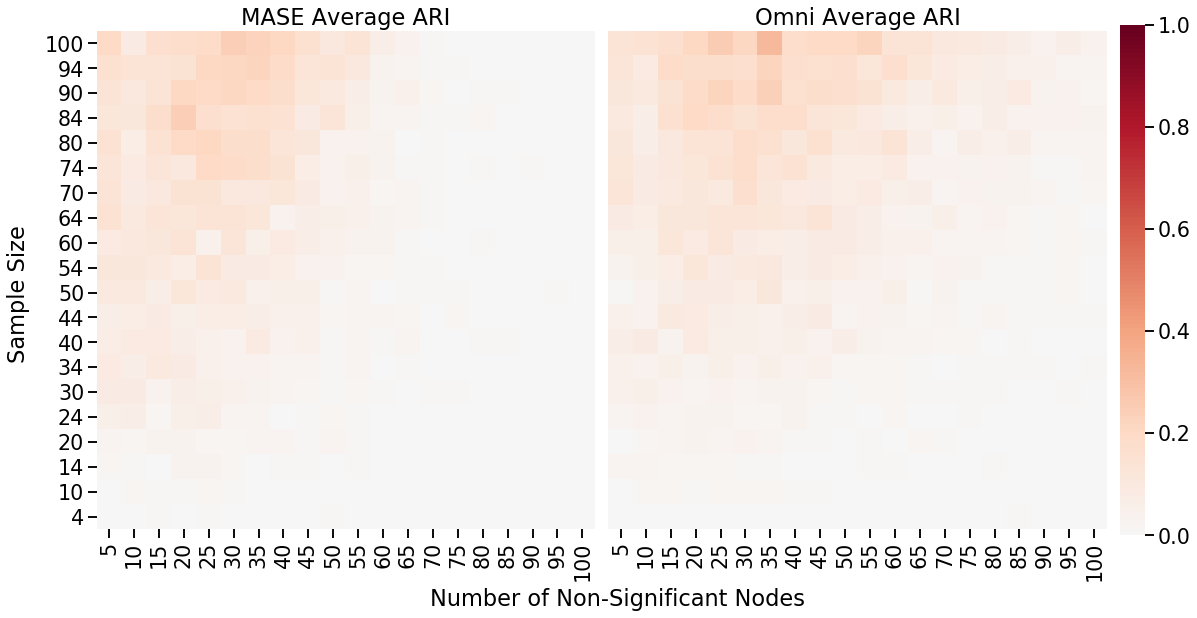

<IPython.core.display.Javascript object>

In [7]:
fmt = lambda x: "{:.2f}".format(x)

with sns.plotting_context("talk", font_scale=1.25):
    fig, ax = plt.subplots(
        1,
        3,
        gridspec_kw={"width_ratios": [1, 1, 0.05]},
        figsize=(16, 8),
        constrained_layout=True,
    )

    sns.heatmap(
        np.flipud(res_df.mase_ari.values.reshape(spacing, -1)),
        ax=ax[0],
        square=True,
        center=0,
        cmap="RdBu_r",
        cbar_kws=dict(shrink=0.7),
        xticklabels=num_non_sig_nodes,
        yticklabels=ms[::-1] * 2,
        cbar_ax=ax[-1],
        vmin=0,
        vmax=1,
    )
    ax[0].set_title("MASE Average ARI")

    sns.heatmap(
        np.flipud(res_df.omni_ari.values.reshape(spacing, -1)),
        ax=ax[1],
        square=True,
        center=0,
        cmap="RdBu_r",
        cbar_kws=dict(shrink=0.7),
        cbar=False,
        xticklabels=num_non_sig_nodes,
        yticklabels=[],
        # cbar_ax=ax[-1],
        vmin=0,
        vmax=1,
    )
    ax[1].set_title("Omni Average ARI")

    fig.text(-0.03, 0.5, "Sample Size", va="center", rotation="vertical")
    fig.text(0.5, -0.03, "Number of Non-Significant Nodes", va="center", ha="center")

    fig.savefig(
        "./figures/20200130_vary_non_sig_nodes.png", dpi=300, bbox_inches="tight"
    )